  0%|          | 0/1020 [00:00<?, ?it/s]

RMSD Results Attributes: ['_MutableMapping__marker', '__abstractmethods__', '__class__', '__contains__', '__copy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__setattr__', '__setitem__', '__setstate__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_validate_key', 'clear', 'copy', 'data', 'fromkeys', 'get', 'items', 'keys', 'pop', 'popitem', 'setdefault', 'update', 'values']
RMSD Results Data: {'rmsd': array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 4.88882100e-02, 1.38896779e-01],
       [2.00000000e+00, 9.77764200e-02, 1.81566548e-01],
       ...,
       [1.01700000e+03, 4.97193096e+01, 3.86020484e-01

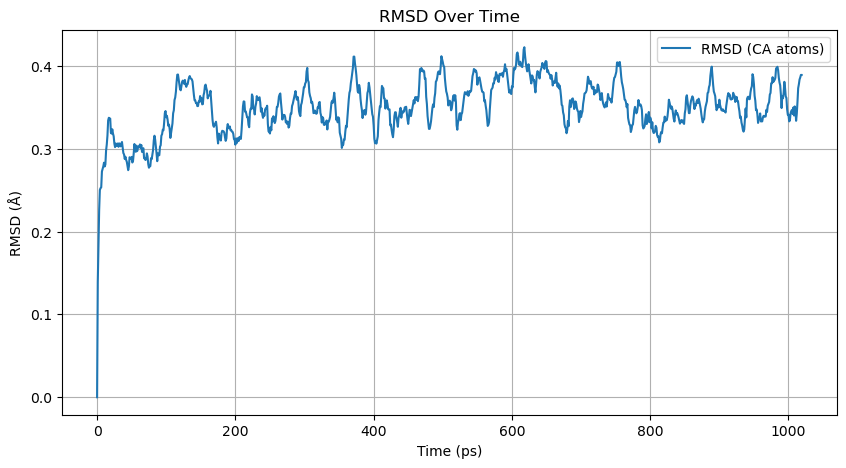

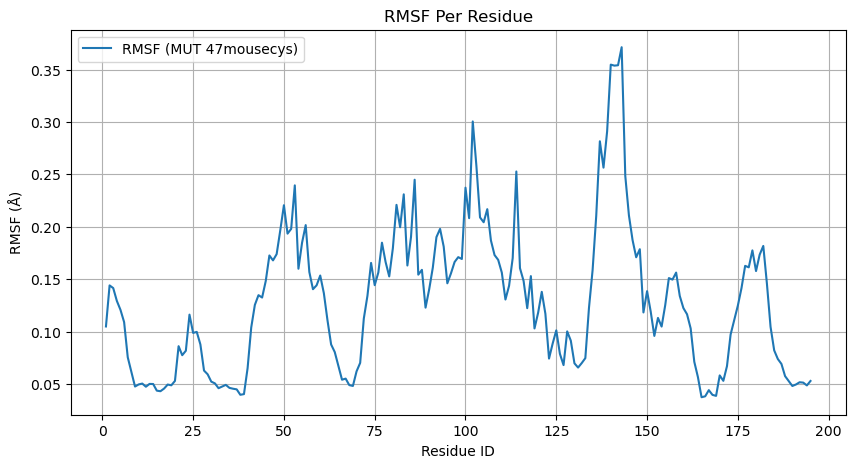

In [10]:
import MDAnalysis as mda
from MDAnalysis.analysis import rms, align
import numpy as np
import matplotlib.pyplot as plt

# Load the structure (PDB) and trajectory (DCD) files
u = mda.Universe('47minim.pdb', 'combined.dcd')

# Select the atom group for analysis (e.g., protein C-alpha atoms)
protein = u.select_atoms('protein and name CA')

# Calculate RMSD
rmsd = rms.RMSD(protein, reference=protein, select='protein and name CA', verbose=True)
rmsd.run()

# Print available attributes of the RMSD results object
print("RMSD Results Attributes:", dir(rmsd.results))

# Check what data is available in rmsd.results
print("RMSD Results Data:", rmsd.results.data)

# Extract RMSD data
try:
    rmsd_data = rmsd.results.data
    # Check the structure of rmsd_data
    print("RMSD Data Structure:", rmsd_data)
    
    # Extract time and RMSD values if possible
    rmsd_time = np.arange(len(rmsd_data))  # Fallback if time is missing
    rmsd_values = rmsd_data[:, 2]  # Assuming RMSD values are in the third column
except Exception as e:
    print(f"Error accessing RMSD data: {e}")
    rmsd_time = np.arange(len(rmsd.results.rmsd))  # Fallback if time is missing
    rmsd_values = rmsd.results.rmsd[:, 2]  # Assuming RMSD values are still accessible

# Align the trajectory to the reference (first frame) to remove global movements
alignment = align.AlignTraj(u, u, select='protein and name CA', in_memory=True)
alignment.run()  # Perform alignment

# After alignment, use the original Universe to select atoms
aligned_u = u  # After alignment, u is updated
ca_atoms = aligned_u.select_atoms('protein and name CA')

# Manually calculate RMSF
num_residues = len(ca_atoms.residues)
num_frames = len(aligned_u.trajectory)
rmsf_values = np.zeros(num_residues)

# Collect positions
all_positions = np.zeros((num_frames, num_residues, 3))
for i, ts in enumerate(aligned_u.trajectory):
    all_positions[i] = ca_atoms.positions

# Calculate mean position per residue
mean_positions = all_positions.mean(axis=0)

# Calculate RMSF
for i, res in enumerate(ca_atoms.residues):
    deviations = all_positions[:, i] - mean_positions[i]
    rmsf_values[i] = np.sqrt((deviations ** 2).mean())

# Get residue IDs
resids = [res.resid for res in ca_atoms.residues]

# Plot RMSD
plt.figure(figsize=(10, 5))
plt.plot(rmsd_time, rmsd_values, label='RMSD (CA atoms)')
plt.xlabel('Time (ps)')
plt.ylabel('RMSD (Å)')
plt.title('RMSD Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot RMSF
plt.figure(figsize=(10, 5))
plt.plot(resids, rmsf_values, label='RMSF (MUT 47mousecys)')
plt.xlabel('Residue ID')
plt.ylabel('RMSF (Å)')
plt.title('RMSF Per Residue')
plt.legend()
plt.grid(True)
plt.show()
